Potting Data Analysis - New Routine
===================================

This notebook will contain analysis of the data saved in logfiles by the new module potting routine.

First, one must prepare the datafiles.
  1. Log into the t3
  2. execute the following command to create an archive of all potting data 
      ```sh
      zip -uj Potting_Logs.zip /home/dominguez/cfangmeier/elog_git/logbooks/SiLab_Logbook/*/*_Config-*-*-*.zip
      ```
  3. Copy Potting_Logs.zip into the same directory as this notebook
  4. Run the script to convert the logfiles to JSON
     ```sh
     ./PottingLog2JSON.py Potting_Logs.zip
     ```

Alternatively, You can just run the pre-prepared script to automate these steps. Note that you must give the script your t3 username as the first argument so it can execute the scp and ssh commands appropriately.

After running the above, the resulting json can be read in and processed.

In [46]:
%matplotlib notebook
from IPython.display import Markdown, display_markdown
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import itertools
import collections
import json
import pprint

plt.style.use('fivethirtyeight')
plt_cols = itertools.cycle([col['color'] for col in plt.rcParams['axes.prop_cycle']._left])

In [47]:
dec = json.JSONDecoder()
with open('Potting_Logs.json','r') as f:
    modules = dec.decode(f.read())
# pprint.pprint(modules[1])

In [48]:
def net_phi(quat):
    from Quaternion import Quat
    quat = [float(q) for q in quat]
    quat = Quat(quat)
    v = np.array([1,0,0])
    v = quat.transform @ v
    return np.arctan2(v[1],v[0]) * 180/np.pi

ss = ['|   | Session ID | Module ID | Operator | Date | Time (min) | Chuck | Slot | Offset ($\mu$m) | $\phi_{HDI}$ | $\phi_{BBM}$ | $\phi_{net}$ | 4cm*$\sin(\phi_{net})$ ($\mu$m)|',
      '|---|------------|-----------|----------|------|-----------:|------:|-----:|----------------:|-------------:|-------------:|-------------:|--------------------------------|']
for i, module in enumerate(modules):
    module_id = module.get('id','N/A')
    operator = module.get('operator_name','n/a').title()
    try:
        dt = module['date_potted']
        date = "{:02d}/{:02d}/{:04d}".format(dt['month'], dt['day'], dt['year'])
    except Exception:
        date = "N/A"
    time = module.get('time',0)
    session_id = module['source_file']
    chuck = int(module.get('chuck','N/A'))
    slot = int(module.get('slot', 'N/A'))
    bbm_center = [float(x) for x in module['BBM_center']][:2]
    hdi_center = [float(x) for x in module['HDI_center']][:2]
    offset = sum((x-y)**2 for x,y in zip(bbm_center, hdi_center))**.5
    offset *= 1000
    rot_bbm = net_phi(module['BBM_orient'])
    rot_hdi = net_phi(module['HDI_orient'])
    rot_net = abs(rot_bbm - rot_hdi)
    edge_delta = 4*10000*np.sin(rot_net * (np.pi/180))
    s = ("|{i}|{session_id}|{module_id}|{op}|{date}|{time}|{chuck:02d}|{slot:02d}|{offset:.03f}"
         "|{rot_hdi:.03f}°|{rot_bbm:.03f}°|{rot_net:.03f}°|{edge_delta:.03f}|")
    s = s.format(i=i+1, session_id=session_id, module_id=module_id, op=operator, date=date, time=time,
                 chuck=chuck, slot=slot, offset=offset, rot_hdi=rot_hdi,
                 rot_bbm=rot_bbm, rot_net=rot_net, edge_delta=edge_delta)
    ss.append(s)
m = Markdown('\n'.join(ss))

<IPython.core.display.Javascript object>


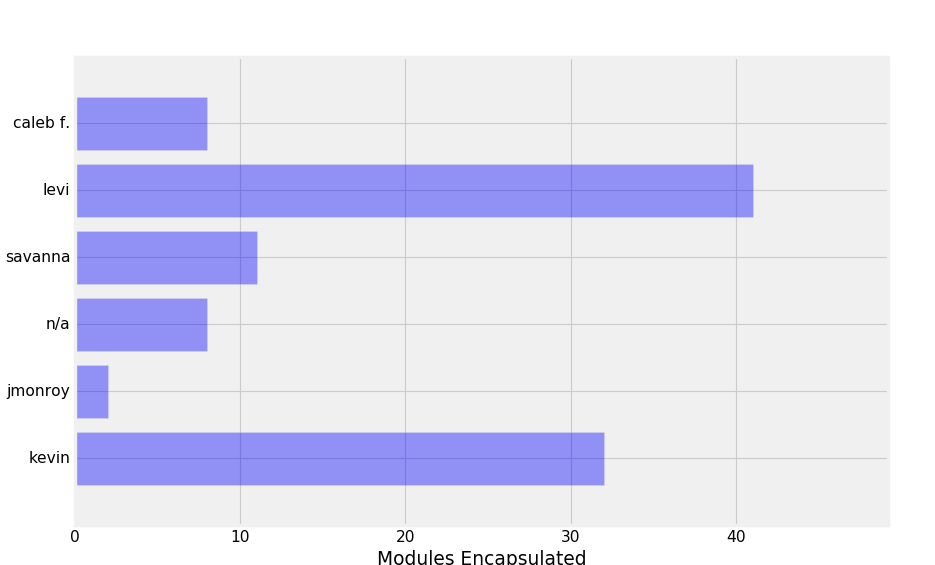

|   | Session ID | Module ID | Operator | Date | Time (min) | Chuck | Slot | Offset ($\mu$m) | $\phi_{HDI}$ | $\phi_{BBM}$ | $\phi_{net}$ | 4cm*$\sin(\phi_{net})$ ($\mu$m)|
|---|------------|-----------|----------|------|-----------:|------:|-----:|----------------:|-------------:|-------------:|-------------:|--------------------------------|
|1|2016_03_30-14_51-000|M-K-2-43|N/A|03/30/2016|26|02|02|16.554|-0.312°|-0.147°|0.165°|115.443|
|2|2016_03_30-14_51-000|M-K-2-35|N/A|03/30/2016|26|02|01|27.168|-0.417°|-0.228°|0.189°|131.761|
|3|2016_03_30-16_09-000|M-K-2-42|N/A|03/30/2016|25|02|02|38.821|-0.350°|-0.165°|0.185°|129.213|
|4|2016_03_30-16_09-000|M-K-2-34|N/A|03/30/2016|25|02|01|22.060|-0.275°|-0.207°|0.069°|48.050|
|5|2016_03_31-15_21-000|M-L-4-07|N/A|03/31/2016|39|02|03|43.366|-0.098°|0.010°|0.108°|75.162|
|6|2016_03_31-16_51-000|M-L-4-29|N/A|03/31/2016|33|02|01|18.969|-0.176°|0.016°|0.192°|134.077|
|7|2016_03_31-17_39-000|M-L-4-40|N/A|03/31/2016|28|02|02|31.480|-0.168°|0.050°|0.218°|152.039|
|8|2016_04_01-10_26-000|M-L-4-50|N/A|04/01/2016|36|02|03|27.084|-0.145°|0.044°|0.189°|132.152|
|9|2016_04_01-11_30-000|M-K-2-01|Savanna|04/01/2016|31|02|01|16.859|0.069°|-0.075°|0.144°|100.561|
|10|2016_04_04-13_21-000|M-K-2-38|Kevin|04/04/2016|33|02|02|20.271|0.081°|-0.073°|0.154°|107.260|
|11|2016_04_04-14_05-000|M-L-1-07|Kevin|04/04/2016|30|02|04|17.198|0.056°|-0.099°|0.155°|108.094|
|12|2016_04_04-14_43-000|M-L-1-08|Kevin|04/04/2016|29|02|01|25.764|-0.090°|0.079°|0.169°|118.090|
|13|2016_04_04-15_19-000|M-L-2-18|Kevin|04/04/2016|31|02|02|28.672|-0.285°|-0.019°|0.267°|186.079|
|14|2016_04_05-09_19-000|M-L-1-23|Levi|04/05/2016|35|02|03|28.592|-0.290°|-0.159°|0.131°|91.613|
|15|2016_04_05-10_08-000|M-L-1-43|Levi|04/05/2016|31|02|04|29.185|-0.362°|-0.171°|0.192°|134.016|
|16|2016_04_06-14_16-000|M-L-2-15|Levi|04/06/2016|32|02|01|27.227|-0.174°|-0.056°|0.117°|81.891|
|17|2016_04_06-14_57-000|M-L-2-29|Levi|04/06/2016|32|02|02|41.115|-0.213°|-0.021°|0.192°|134.100|
|18|2016_04_06-15_38-000|M-L-2-34|Levi|04/06/2016|31|02|04|41.710|-0.159°|0.020°|0.179°|124.622|
|19|2016_04_06-16_23-000|M-L-2-07|Levi|04/06/2016|29|02|01|32.402|-0.321°|0.037°|0.357°|249.519|
|20|2016_04_11-13_10-000|M-L-4-10|Kevin|04/11/2016|23|02|02|22.346|-0.195°|-0.173°|0.022°|15.366|
|21|2016_04_11-13_10-000|M-K-1-29|Kevin|04/11/2016|23|02|01|30.444|-0.256°|-0.196°|0.060°|41.839|
|22|2016_04_11-14_09-000|M-L-4-27|Kevin|04/11/2016|22|02|03|24.877|-0.200°|-0.197°|0.003°|2.098|
|23|2016_04_11-14_09-000|M-K-2-08|Kevin|04/11/2016|22|02|04|20.607|-0.182°|-0.181°|0.002°|1.059|
|24|2016_04_11-15_04-000|M-L-2-44|Kevin|04/11/2016|23|02|03|36.275|-0.055°|0.021°|0.075°|52.652|
|25|2016_04_11-15_04-000|M-L-2-45|Kevin|04/11/2016|23|02|04|29.916|-0.030°|0.017°|0.046°|32.300|
|26|2016_04_12-09_11-000|M-L-2-32|Levi|04/12/2016|23|02|02|21.078|-0.034°|-0.090°|0.056°|38.903|
|27|2016_04_12-09_11-000|M-K-2-44|Levi|04/12/2016|23|02|01|10.809|-0.016°|-0.067°|0.051°|35.527|
|28|2016_04_12-10_15-000|M-L-2-42|Levi|04/12/2016|23|02|03|24.616|-0.002°|-0.112°|0.110°|76.768|
|29|2016_04_12-10_15-000|M-M-4-02|Levi|04/12/2016|23|02|04|21.166|0.072°|-0.092°|0.164°|114.167|
|30|2016_04_13-15_24-000|M-M-4-11|Kevin|04/13/2016|21|02|02|16.849|0.123°|-0.101°|0.224°|156.305|
|31|2016_04_13-15_24-000|M-M-4-06|Kevin|04/13/2016|21|02|01|22.326|0.001°|-0.079°|0.080°|56.033|
|32|2016_04_13-16_20-000|M-M-4-12|Kevin|04/13/2016|21|02|03|23.436|0.054°|-0.078°|0.132°|91.824|
|33|2016_04_13-16_20-000|M-M-4-41|Kevin|04/13/2016|21|02|04|24.971|0.077°|-0.094°|0.171°|119.140|
|34|2016_04_14-11_25-000|M-M-1-35|Caleb F.|04/14/2016|109|03|02|18.850|0.015°|0.104°|0.089°|62.018|
|35|2016_04_14-11_25-000|M-M-2-50|Caleb F.|04/14/2016|109|02|03|35.774|-0.111°|-0.008°|0.103°|72.239|
|36|2016_04_14-11_25-000|M-L-3-14|Caleb F.|04/14/2016|109|02|04|49.596|0.006°|0.036°|0.030°|21.243|
|37|2016_04_14-11_25-000|M-K-3-18|Caleb F.|04/14/2016|109|03|01|27.334|0.060°|0.113°|0.053°|37.066|
|38|2016_04_14-11_25-000|M-M-2-10|Caleb F.|04/14/2016|109|02|02|21.825|-0.251°|0.067°|0.318°|221.916|
|39|2016_04_14-11_25-000|M-M-1-43|Caleb F.|04/14/2016|109|02|01|8.080|-0.191°|0.063°|0.253°|176.946|
|40|2016_04_14-11_25-000|M-M-2-09|Caleb F.|04/14/2016|109|03|03|20.411|-0.064°|0.136°|0.200°|139.299|
|41|2016_04_14-11_25-000|M-L-2-11|Caleb F.|04/14/2016|109|03|04|15.772|0.037°|0.127°|0.090°|62.719|
|42|2016_04_15-09_52-000|M-L-3-39|Savanna|04/15/2016|25|02|02|56.474|-0.057°|0.043°|0.100°|69.646|
|43|2016_04_15-09_52-000|M-L-3-24|Savanna|04/15/2016|25|02|01|37.835|-0.026°|0.008°|0.034°|24.064|
|44|2016_04_18-13_50-000|M-M-1-05|Kevin|04/18/2016|20|02|02|18.427|-0.264°|-0.099°|0.165°|115.214|
|45|2016_04_18-13_50-000|M-L-1-33|Kevin|04/18/2016|20|02|04|27.093|-0.395°|-0.194°|0.200°|139.950|
|46|2016_04_19-09_10-000|M-NQ|Levi|04/19/2016|21|02|04|29.155|-0.236°|0.101°|0.337°|235.391|
|47|2016_04_19-09_10-000|K-NH|Levi|04/19/2016|21|02|02|49.396|0.216°|0.045°|0.171°|119.301|
|48|2016_04_19-09_10-000|Q-NC|Levi|04/19/2016|21|02|01|28.982|0.077°|0.028°|0.049°|34.528|
|49|2016_04_19-10_40-000|M-Y-Q-NE|Levi|04/19/2016|16|02|02|20.967|-0.165°|-0.122°|0.043°|29.927|
|50|2016_04_19-10_40-000|M-Y-A-NJ|Levi|04/19/2016|16|02|01|102.638|-0.016°|-0.071°|0.055°|38.391|
|51|2016_04_19-10_40-000|M-L-3-40|Levi|04/19/2016|16|03|01|24.804|-0.372°|-0.213°|0.159°|111.120|
|52|2016_04_19-11_31-000|M-L-3-40|Levi|04/19/2016|24|03|01|21.415|-0.373°|-0.212°|0.161°|112.496|
|53|2016_04_20-14_04-000|M-Y-S-NA|Levi|04/20/2016|16|02|04|20.695|-0.130°|0.050°|0.180°|125.632|
|54|2016_04_20-14_04-000|M-Y-M-NS|Levi|04/20/2016|16|02|03|38.208|-0.097°|0.040°|0.137°|95.474|
|55|2016_04_20-14_04-000|M-Y-M-NC|Levi|04/20/2016|16|02|02|25.934|-0.135°|0.078°|0.213°|148.886|
|56|2016_04_20-14_04-000|M-M-1-38|Levi|04/20/2016|16|02|01|25.036|-0.089°|0.048°|0.137°|95.563|
|57|2016_04_20-14_04-000|M-L-3-40|Levi|04/20/2016|16|03|04|25.665|-0.193°|-0.027°|0.166°|115.684|
|58|2016_04_22-09_41-000|M-L-2-50|Savanna|04/22/2016|21|04|01|14.354|-0.136°|0.002°|0.138°|96.245|
|59|2016_04_22-09_41-000|M-L-3-01|Savanna|04/22/2016|21|04|02|42.808|-0.140°|-0.037°|0.104°|72.380|
|60|2016_04_22-16_20-000|M-L-3-06|Savanna|04/22/2016|20|05|04|45.740|-0.255°|-0.130°|0.125°|87.138|
|61|2016_04_22-16_20-000|M-L-3-05|Savanna|04/22/2016|20|05|03|38.252|-0.237°|-0.110°|0.127°|88.560|
|62|2016_04_25-12_33-000|M-M-2-20|Kevin|04/25/2016|198|02|04|23.487|-0.321°|-0.164°|0.157°|109.787|
|63|2016_04_25-12_33-000|M-M-3-21|Kevin|04/25/2016|198|02|03|25.424|-0.369°|-0.238°|0.131°|91.497|
|64|2016_04_25-12_33-000|M-I-4-04|Kevin|04/25/2016|198|02|02|27.736|-0.325°|-0.155°|0.170°|118.572|
|65|2016_04_25-12_33-000|M-K-3-43|Kevin|04/25/2016|198|02|01|29.143|-0.367°|-0.199°|0.168°|117.305|
|66|2016_04_25-14_07-000|M-M-3-06|Kevin|04/25/2016|17|02|04|27.186|-0.080°|0.048°|0.128°|89.039|
|67|2016_04_25-14_07-000|M-M-2-49|Kevin|04/25/2016|17|02|03|21.924|-0.054°|0.049°|0.103°|72.036|
|68|2016_04_25-14_07-000|M-M-2-39|Kevin|04/25/2016|17|02|02|33.889|-0.037°|0.006°|0.043°|29.998|
|69|2016_04_25-14_07-000|M-M-2-30|Kevin|04/25/2016|17|02|01|27.996|-0.018°|-0.012°|0.007°|4.673|
|70|2016_04_26-09_15-000|M-M-3-16|Levi|04/26/2016|25|02|03|30.715|-0.265°|0.037°|0.302°|210.983|
|71|2016_04_26-09_15-000|M-M-3-08|Levi|04/26/2016|25|02|02|29.128|-0.252°|0.064°|0.316°|220.717|
|72|2016_04_26-09_15-000|M-N-3-04|Levi|04/26/2016|25|02|01|27.541|-0.197°|0.065°|0.263°|183.362|
|73|2016_04_26-10_56-000|M-N-3-25|Levi|04/26/2016|18|02|04|29.830|-0.104°|0.044°|0.149°|103.688|
|74|2016_04_26-10_56-000|M-Y-P-NW|Levi|04/26/2016|18|02|03|35.545|-0.120°|0.059°|0.180°|125.457|
|75|2016_04_26-10_56-000|M-M-3-20|Levi|04/26/2016|18|02|02|38.538|-0.085°|0.009°|0.094°|65.846|
|76|2016_04_26-10_56-000|M-M-1-41|Levi|04/26/2016|18|02|01|33.077|-0.064°|0.000°|0.064°|44.656|
|77|2016_04_27-14_00-000|M-N-3-27|Levi|04/27/2016|18|02|04|16.273|-0.045°|-0.078°|0.032°|22.562|
|78|2016_04_27-14_00-000|M-N-3-38|Levi|04/27/2016|18|02|03|23.718|0.014°|-0.069°|0.083°|58.243|
|79|2016_04_27-14_00-000|M-M-4-43|Levi|04/27/2016|18|02|02|29.367|-0.003°|-0.107°|0.104°|72.823|
|80|2016_04_27-14_00-000|M-M-4-05|Levi|04/27/2016|18|02|01|18.517|-0.020°|-0.135°|0.115°|80.430|
|81|2016_04_27-15_40-000|M-N-3-35|Levi|04/27/2016|18|02|04|13.144|-0.190°|0.017°|0.207°|144.411|
|82|2016_04_27-15_40-000|M-N-3-20|Levi|04/27/2016|18|02|03|31.811|-0.124°|0.012°|0.136°|94.827|
|83|2016_04_27-15_40-000|M-N-3-06|Levi|04/27/2016|18|02|02|32.128|-0.106°|0.064°|0.170°|118.494|
|84|2016_04_27-15_40-000|M-M-3-23|Levi|04/27/2016|18|02|01|23.690|-0.089°|0.041°|0.130°|90.567|
|85|2016_04_28-11_04-000|M-Y-P-NE|Savanna|04/28/2016|18|02|04|17.392|-0.249°|0.068°|0.317°|221.292|
|86|2016_04_28-11_04-000|M-Y-J-NX|Savanna|04/28/2016|18|02|03|33.091|-0.143°|0.050°|0.193°|134.641|
|87|2016_04_28-11_04-000|M-Y-H-NE|Savanna|04/28/2016|18|02|02|33.317|-0.174°|0.025°|0.198°|138.471|
|88|2016_04_28-11_04-000|M-N-3-40|Savanna|04/28/2016|18|02|01|31.971|-0.109°|-0.002°|0.106°|74.187|
|89|2016_05_02-14_59-000|M-Y-D-NN|Kevin|05/02/2016|18|02|04|16.836|-0.155°|0.050°|0.205°|142.962|
|90|2016_05_02-14_59-000|M-N-3-39|Kevin|05/02/2016|18|02|03|26.968|-0.047°|0.028°|0.075°|52.331|
|91|2016_05_02-14_59-000|M-N-3-19|Kevin|05/02/2016|18|02|02|24.130|-0.153°|0.070°|0.223°|155.759|
|92|2016_05_02-14_59-000|M-N-3-12|Kevin|05/02/2016|18|02|01|14.489|-0.095°|0.053°|0.149°|103.679|
|93|2016_05_05-15_39-000|T-E-S-T2|Jmonroy|05/05/2016|20|02|02|18.223|0.182°|-0.123°|0.305°|212.844|
|94|2016_05_05-15_39-000|T-E-S-T1|Jmonroy|05/05/2016|20|02|01|5.491|0.003°|0.016°|0.012°|8.726|
|95|2016_05_09-14_12-000|M-M-2-39|Kevin|05/09/2016|17|02|04|33.871|0.009°|0.054°|0.045°|31.667|
|96|2016_05_09-14_12-000|M-Y-A-NS|Kevin|05/09/2016|17|02|03|38.105|-0.023°|-0.012°|0.011°|7.804|
|97|2016_05_09-14_12-000|M-Y-S-ND|Kevin|05/09/2016|17|02|02|35.533|-0.079°|0.047°|0.126°|87.762|
|98|2016_05_09-14_12-000|M-Y-J-NL|Kevin|05/09/2016|17|02|01|22.190|0.001°|0.001°|0.001°|0.403|
|99|2016_05_10-09_50-000|M-Y-N-NA|Levi|05/10/2016|20|02|04|21.214|-0.054°|-0.070°|0.016°|11.002|
|100|2016_05_10-09_50-000|M-Y-D-NV|Levi|05/10/2016|20|02|03|30.356|0.026°|-0.022°|0.047°|33.108|
|101|2016_05_10-09_50-000|M-Y-B-NY|Levi|05/10/2016|20|02|02|30.812|0.033°|0.014°|0.019°|13.116|
|102|2016_05_10-09_50-000|M-Y-A-NN|Levi|05/10/2016|20|02|01|31.286|0.064°|0.008°|0.056°|38.868|

In [49]:
ops = collections.defaultdict(int)
for module in modules:
    op = module.get('operator_name','N/A').lower()
    ops[op] += 1

fig = plt.figure()
ax = fig.gca()
ypos = list(range(len(ops)))
names, counts = zip(*ops.items())
ax.barh(ypos, counts, align='center', alpha=0.4, tick_label=names)
ax.set_xlim((0,max(counts)*1.2))
ax.set_xlabel('Modules Encapsulated')

plt.show()

display_markdown(m)

<IPython.core.display.Javascript object>


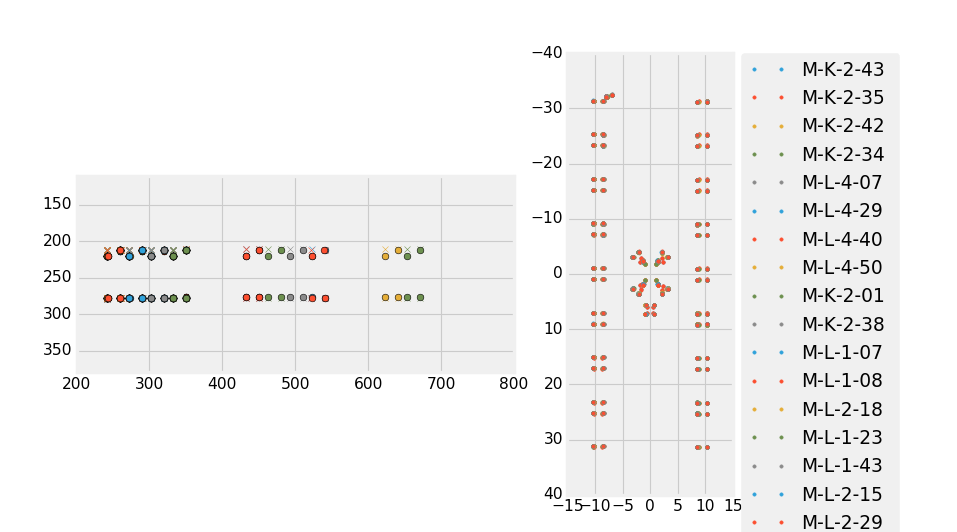

In [50]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1,.7]) 
ax_fid = fig.add_subplot(gs[0], adjustable='box', aspect=1)
ax_pot = fig.add_subplot(gs[1], adjustable='box', aspect=1)
for color, module in zip(plt_cols,modules[:]):
    pts_local = []
    for val in module['pot_lines'].values():
        pts_local.append(val['local']['start'])
        pts_local.append(val['local']['end'])

    xs,ys,zs = zip(*pts_local)
    ax_pot.plot(xs,ys, '.', label=module['id'], color=color)
    pts_local.clear()
    for val in module['BBM_fids'].values():
        pts_local.append(val['fid_pos'])
    xs,ys,zs = zip(*pts_local)
    ax_fid.plot(xs,ys, 'x', label=module['id'], color=color)
    pts_local.clear()
    for val in module['HDI_fids'].values():
        pts_local.append(val['fid_pos'])
    xs,ys,zs = zip(*pts_local)
    ax_fid.plot(xs,ys, 'o', label=module['id'], color=color)
ax_fid.set_ylim((380,110))
ax_pot.set_ylim((40,-40))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<IPython.core.display.Javascript object>


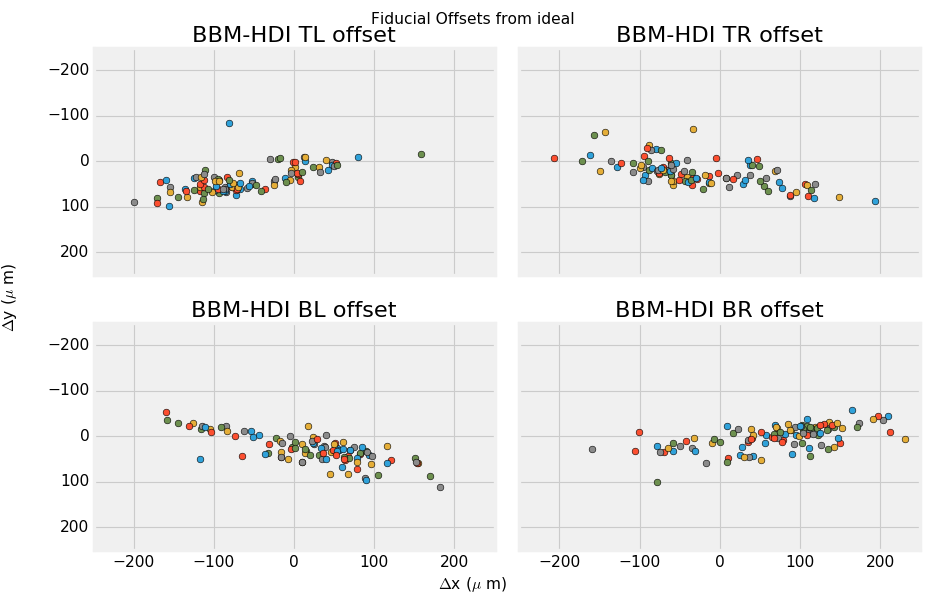

In [51]:
fig, ((ax_tl,ax_tr),(ax_bl,ax_br)) = plt.subplots(nrows=2, ncols=2,
                                                  sharex=True, sharey=True)
ideals = {'fid_TR': [-.39375, .9932, 0],
          'fid_TL': [ .39375,9.0921, 0],
          'fid_BL': [ .39375,-.9932, 0],
          'fid_BR': [-.39375,-.9932, 0]}
fids = ['fid_TR', 'fid_TL', 'fid_BL', 'fid_BR']
for fid, ax in zip(fids, [ax_tr, ax_tl, ax_bl, ax_br]):
    for color, module in zip(plt_cols,modules[:]):
        lb = module['BBM_fids'][fid]['fid_pos']
        lh = module['HDI_fids'][fid]['fid_pos']
        ideal = ideals[fid]
        delta = [(float(dh)-float(db)-idl)*1000 for db, dh, idl in zip(lb, lh, ideal)]
        ax.plot([delta[0]], [delta[1]], 'o', color=color, label=module['id'])
    ax.set_title('BBM-HDI '+fid.split('_')[1]+' offset')
    ax.set_xlim((-250,250))
    ax.set_ylim((250,-250))
        
fig.suptitle('Fiducial Offsets from ideal')

fig.text(0.5, 0.01, '$\Delta$x ($\mu$ m)', ha='center')
fig.text(0.0, 0.5, '$\Delta$y ($\mu$ m)', va='center', rotation='vertical')   
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


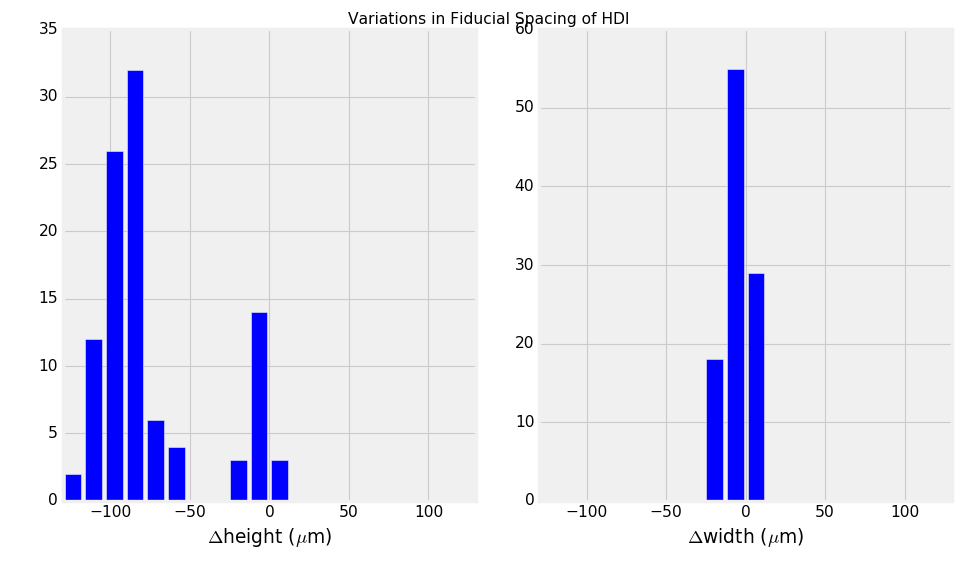

M-NQ       - +6.286
K-NH       - -0.577
Q-NC       - -8.848
M-Y-Q-NE   - -8.315
M-Y-A-NJ   - +1.109
M-Y-S-NA   - -9.007
M-Y-M-NS   - -8.227
M-Y-M-NC   - -4.574
M-Y-P-NW   - -15.737
M-Y-P-NE   - -5.135
M-Y-J-NX   - -1.767
M-Y-H-NE   - +0.483
M-Y-D-NN   - -23.398
M-Y-A-NS   - -3.927
M-Y-S-ND   - -11.316
M-Y-J-NL   - -5.327
M-Y-N-NA   - -8.198
M-Y-D-NV   - -24.511
M-Y-B-NY   - -11.880
M-Y-A-NN   - -11.678


In [52]:
fig, (ax_h,ax_w) = plt.subplots(nrows=1, ncols=2)
ideal_width = 18410.00  # μm
ideal_height = 60869.95  # μm , actually average between left and right spacings(left is smaller)
heights = []
widths = []
for module in modules:
    fids = module['HDI_fids']
    fid_tr = fids['fid_TR']['fid_pos']
    fid_tl = fids['fid_TL']['fid_pos']
    fid_bl = fids['fid_BL']['fid_pos']
    fid_br = fids['fid_BR']['fid_pos']
    def dist(fid1, fid2):
        pairs = [(float(x), float(y)) for x,y in zip(fid1, fid2)]
        return np.sqrt(sum((x-y)**2 for x, y in pairs[:2]))*1000
    left_height = dist(fid_bl, fid_tl)
    right_height = dist(fid_br, fid_tr)
#     print("left height:{}\tright height:{}".format(left_height, right_height))
    height = (left_height+right_height)/2 - ideal_height
    heights.append(height)
    top_width = dist(fid_tl, fid_tr)
    bottom_width = dist(fid_bl, fid_br)
    width = (top_width+bottom_width)/2 - ideal_width
    widths.append(width)
    if(abs(height) < 40):
        print("{:10} - {:+.03f}".format(module['id'], height))
    
def histo(data, ax, xlabel):
    hist, bins = np.histogram(data, bins=20, range=(-130,130))
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlabel(xlabel)
    ax.set_xlim((-130,130))
    
histo(heights, ax_h, '$\Delta$height ($\mu$m)')
histo(widths, ax_w, '$\Delta$width ($\mu$m)')
fig.suptitle('Variations in Fiducial Spacing of HDI')

fig.tight_layout()
plt.show()

In [53]:
import openpyxl as pxl
wb = pxl.load_workbook(open('ProductionModules.xlsx', 'rb'))
ws = wb.get_sheet_by_name('Diving Board')

gluing_data = {}
for i in range(1, 233):
    id_ = ws.cell(row=i, column=1).value
    if not id_: continue
    gluing_data[id_] = (ws.cell(row=i,column=3).value,
                        ws.cell(row=i,column=5).value,
                        ws.cell(row=i,column=4).value)
ss = ['|   | id | stamp | chuck | slot |',
      '|---|----|-------|-------|------|']
for i, module in enumerate(modules):
    try:
        stamp, chuck, slot = gluing_data[module['id']]
        fmt = "|{i}|{id_}|{stamp}|{chuck}|{slot}|"
        ss.append(fmt.format(i=i, id_=module['id'], stamp=stamp, chuck=chuck, slot=slot))
    except KeyError as e:
        print("Missing gluing data for {}".format(module['id']))
display_markdown(Markdown('\n'.join(ss)))  

Missing gluing data for M-L-2-18
Missing gluing data for M-L-3-39
Missing gluing data for M-NQ
Missing gluing data for K-NH
Missing gluing data for Q-NC
Missing gluing data for M-Y-Q-NE
Missing gluing data for M-Y-A-NJ
Missing gluing data for M-Y-S-NA
Missing gluing data for M-Y-M-NS
Missing gluing data for M-Y-M-NC
Missing gluing data for M-M-1-38
Missing gluing data for M-L-2-50
Missing gluing data for M-L-3-01
Missing gluing data for M-L-3-06
Missing gluing data for M-L-3-05
Missing gluing data for M-M-2-20
Missing gluing data for M-M-3-21
Missing gluing data for M-I-4-04
Missing gluing data for M-K-3-43
Missing gluing data for M-M-3-06
Missing gluing data for M-M-2-49
Missing gluing data for M-M-2-39
Missing gluing data for M-M-2-30
Missing gluing data for M-M-3-16
Missing gluing data for M-M-3-08
Missing gluing data for M-N-3-04
Missing gluing data for M-N-3-25
Missing gluing data for M-Y-P-NW
Missing gluing data for M-M-3-20
Missing gluing data for M-M-1-41
Missing gluing data fo

|   | id | stamp | chuck | slot |
|---|----|-------|-------|------|
|0|M-K-2-43|4|2|4|
|1|M-K-2-35|2|2|2|
|2|M-K-2-42|3|2|3|
|3|M-K-2-34|1|2|1|
|4|M-L-4-07|3|2|3|
|5|M-L-4-29|1|2|1|
|6|M-L-4-40|2|2|2|
|7|M-L-4-50|3|2|3|
|8|M-K-2-01|1|1|1|
|9|M-K-2-38|2|1|2|
|10|M-L-1-07|4|1|4|
|11|M-L-1-08|1|1|1|
|13|M-L-1-23|3|1|3|
|14|M-L-1-43|4|1|4|
|15|M-L-2-15|1|2|1|
|16|M-L-2-29|2|2|2|
|17|M-L-2-34|4|2|4|
|18|M-L-2-07|1|1|1|
|19|M-L-4-10|2|2|2|
|20|M-K-1-29|1|2|1|
|21|M-L-4-27|3|2|3|
|22|M-K-2-08|4|2|4|
|23|M-L-2-44|3|1|3|
|24|M-L-2-45|4|1|4|
|25|M-L-2-32|2|1|2|
|26|M-K-2-44|1|1|1|
|27|M-L-2-42|3|1|3|
|28|M-M-4-02|4|1|4|
|29|M-M-4-11|2|1|2|
|30|M-M-4-06|1|1|1|
|31|M-M-4-12|3|1|3|
|32|M-M-4-41|4|1|4|
|33|M-M-1-35|2|1|2|
|34|M-M-2-50|3|2|3|
|35|M-L-3-14|3|2|3|
|36|M-K-3-18|4|2|4|
|37|M-M-2-10|2|2|2|
|38|M-M-1-43|1|2|1|
|39|M-M-2-09|3|1|3|
|40|M-L-2-11|1|1|1|
|42|M-L-3-24|1|2|1|
|43|M-M-1-05|1|1|1|
|44|M-L-1-33|1|2|1|
|50|M-L-3-40|4|1|4|
|51|M-L-3-40|4|1|4|
|56|M-L-3-40|4|1|4|

<IPython.core.display.Javascript object>


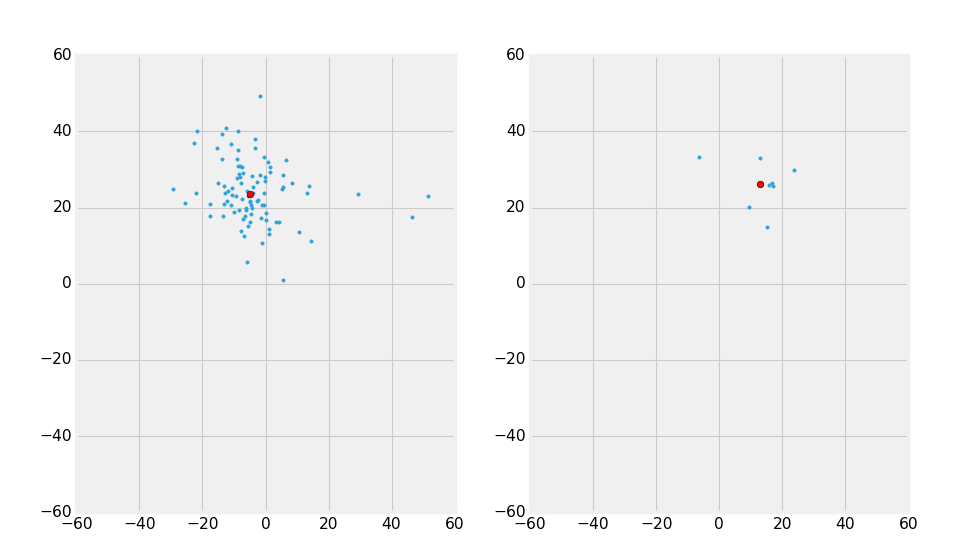

In [54]:
fig, (ax_pre, ax_post) = plt.subplots(nrows=1, ncols=2)
def plot_offset(ax, modules):
    xs = []
    ys = []
    for module in modules:
        bbm_center = [float(x)*1000 for x in module['BBM_center']]
        hdi_center = [float(x)*1000 for x in module['HDI_center']]
        xs.append(hdi_center[0] - bbm_center[0])
        ys.append(hdi_center[1] - bbm_center[1])
    ax.plot(xs,ys,'.')
    ax.plot([np.mean(xs)], [np.mean(ys)], 'or')
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
plot_offset(ax_pre, modules[:-8])
plot_offset(ax_post, modules[-8:])
plt.show()

<IPython.core.display.Javascript object>


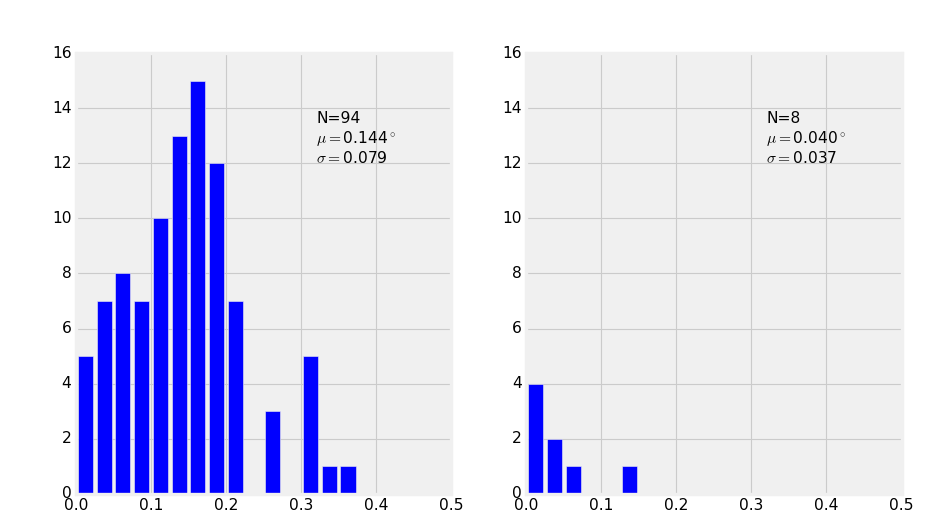

In [58]:
fig, (ax_pre, ax_post) = plt.subplots(nrows=1, ncols=2)
def histo2(ax, modules):
    data = []
    for module in modules:
        rot_bbm = net_phi(module['BBM_orient'])
        rot_hdi = net_phi(module['HDI_orient'])
        data.append(abs(rot_bbm - rot_hdi))
    hist, bins = np.histogram(data, bins=20, range=(0,.5))
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlim((0,.5))
    ax.set_ylim((0,16))
    label = "N={:d}\n$\mu=${:0.3f}$^\circ$\n$\sigma=${:0.3f}".format(len(data), np.mean(data), np.std(data))
    ax.text(0.32, 12, label)

histo2(ax_pre, modules[:-8])
histo2(ax_post, modules[-8:])
plt.show()

<IPython.core.display.Javascript object>


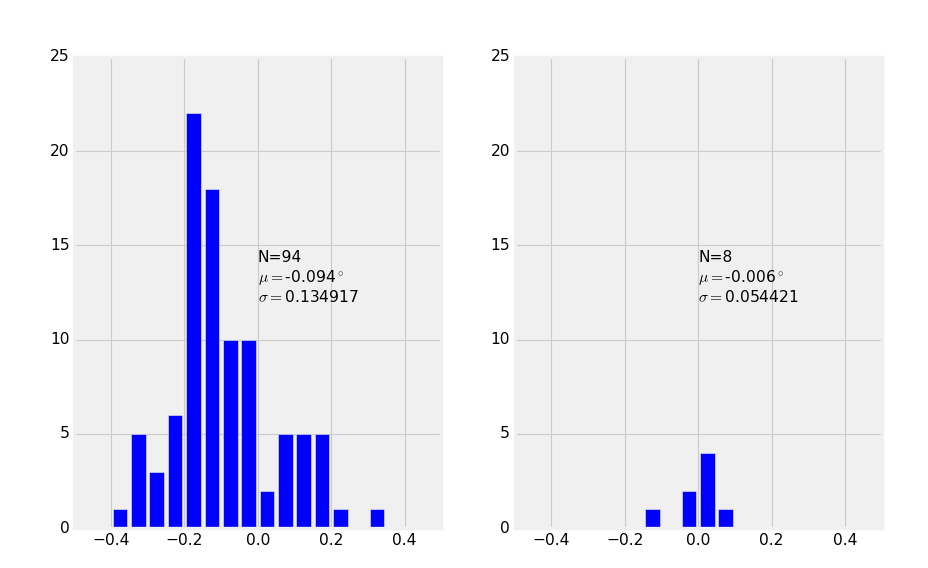

In [56]:
fig, (ax_pre, ax_post) = plt.subplots(nrows=1, ncols=2)
def histo2(ax, modules):
    data = []
    for module in modules:
        rot_bbm = net_phi(module['BBM_orient'])
        rot_hdi = net_phi(module['HDI_orient'])
        data.append(rot_hdi - rot_bbm)
    hist, bins = np.histogram(data, bins=20, range=(-.5,.5))
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlim((-.5,.5))
    ax.set_ylim((0,25))
    label = "N={:d}\n$\mu=${:0.3f}$^\circ$\n$\sigma=${:0.3f}".format(len(data), np.mean(data), np.std(data))
    ax.text(0, 12, label)

histo2(ax_pre, modules[:-8])
histo2(ax_post, modules[-8:])
plt.show()